<a href="https://colab.research.google.com/github/SamiraHabib/System_Recomendation_AV2-IA-/blob/main/IA_AV2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**SISTEMA DE RECOMENDAÇÃO** - 
    
    RECOMENDAÇÃO DE LIVROS

####Imports

In [ ]:
!pip install -q scikit-surprise
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

####Dataset

##### - Books

In [ ]:
books = pd.read_csv("/content/Books.csv", encoding='latin-1', nrows=70000)
print('Rows:', books.shape[0], '/ Columns:', books.shape[1], '\n')
books.head()

Rows: 70000 / Columns: 8 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


##### - Ratings

In [ ]:
ratings = pd.read_csv("/content/Ratings.csv", encoding='latin-1', nrows=60000)
print('Rows:', ratings.shape[0], '/ Columns:', ratings.shape[1], '\n')
ratings

Rows: 60000 / Columns: 3 



,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
59995,11993,1565845609,0
59996,11993,1567314619,0
59997,11993,1567315267,0
59998,11993,1568654847,0


In [ ]:
ratings['Book-Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

##### - User

In [ ]:
user = pd.read_csv("/content/Users.csv", encoding='latin-1', nrows=70000)
print('Rows:', user.shape[0], '/ Columns:', user.shape[1], '\n')
user.head()

Rows: 70000 / Columns: 3 



,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


####Conhecendo os dataframes

In [ ]:
print("Book Shape: " ,books.shape )
print("Rating Shape: " ,ratings.shape )
print("User Shape: " ,user.shape )

Book Shape:  (70000, 8)
Rating Shape:  (60000, 3)
User Shape:  (70000, 3)


In [ ]:
print( "Books: \n\n\n", books.describe(), "\n\n\nRatings: \n\n\n",  ratings.describe(), "\n\n\nUsers:\n\n\n", user.describe())

Books: 


        Year-Of-Publication
count         70000.000000
mean           1959.349329
std             262.260909
min               0.000000
25%            1990.000000
50%            1996.000000
75%            2000.000000
max            2030.000000 


Ratings: 


              User-ID   Book-Rating
count   60000.000000  60000.000000
mean    50825.012417      3.388050
std     98986.343091      3.952846
min         2.000000      0.000000
25%      5790.000000      0.000000
50%      9737.000000      0.000000
75%     11676.000000      8.000000
max    278854.000000     10.000000 


Users:


             User-ID           Age
count  70000.000000  42078.000000
mean   35000.500000     34.848543
std    20207.403759     14.594292
min        1.000000      0.000000
25%    17500.750000     24.000000
50%    35000.500000     32.000000
75%    52500.250000     44.000000
max    70000.000000    244.000000


In [ ]:
print("Quantidade de nulos em Books:\n" ,books.isnull().sum())
print("\n\nQuantidade de nulos em Ratings:\n",ratings.isnull().sum())
print("\n\nQuantidade de nulos em Users:\n",user.isnull().sum())

Quantidade de nulos em Books:
 ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64


Quantidade de nulos em Ratings:
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


Quantidade de nulos em Users:
 User-ID         0
Location        0
Age         27922
dtype: int64


##Preprocessamento

#### Juntando os dataframes

In [ ]:
df_location = ratings.merge(user, on='User-ID')
df_location.head()

,User-ID,ISBN,Book-Rating,Location,Age
0,2,0195153448,0,"stockton, california, usa",18.0
1,7,034542252,0,"washington, dc, usa",NaN
2,8,0002005018,5,"timmins, ontario, canada",NaN
3,8,0060973129,0,"timmins, ontario, canada",NaN
4,8,0374157065,0,"timmins, ontario, canada",NaN


In [ ]:
df_book = ratings.merge(books,on="ISBN")
df_book.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [ ]:
df=df_book.copy()
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=["Book-Author","Image-URL-S","Image-URL-M","Image-URL-L"],axis=1,inplace=True)
df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
df.rename(columns = {'ISBN': 'Book_ID','Book-Title':'Book_Title', 'User-ID': 'User_ID', 'Book-Rating': 'Book_Rating', 'Year-Of-Publication': 'Year_Book'}, inplace = True)
df.head()

,User_ID,Book_ID,Book_Rating,Book_Title,Year_Book,Publisher
1,2313,034545104X,5,Flesh Tones A Novel,2002,Ballantine Books
3,8680,034545104X,5,Flesh Tones A Novel,2002,Ballantine Books
4,10314,034545104X,9,Flesh Tones A Novel,2002,Ballantine Books
9,7158,0446520802,10,The Notebook,1996,Warner Books
10,8253,0446520802,10,The Notebook,1996,Warner Books


In [ ]:
df['Book_ID'].nunique()

13881

In [ ]:
df.shape

(18940, 6)

##Agrupando dados

In [ ]:
df_rating = df.groupby(by=['Book_Rating']).agg({'User_ID': 'count'}).reset_index()
df_rating.columns = ['Rating', 'Count']

#####Visualização dos dados

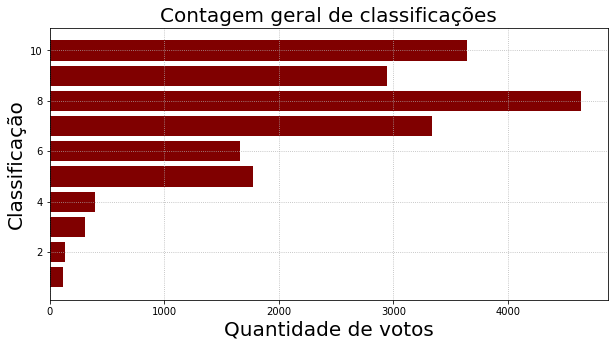

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.barh(df_rating.Rating, df_rating.Count, color='maroon')
plt.title('Contagem geral de classificações', fontsize=20)
plt.xlabel('Quantidade de votos', fontsize=20)
plt.ylabel('Classificação', fontsize=20)
plt.grid(ls='dotted')
plt.show()

In [ ]:
df_visualization = df.groupby('User_ID').Book_Rating.count().sort_values(ascending=False)

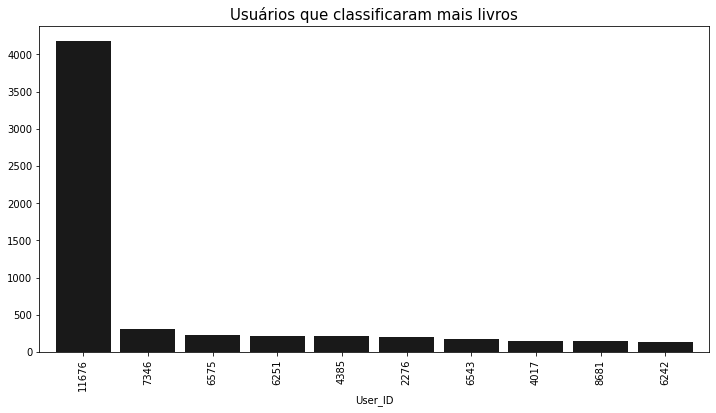

In [ ]:
# Plotando o top 10 raters
plt.figure(figsize=(12,6))
df_visualization.head(10).plot(kind='bar', alpha=0.9, width=0.85, color='black')
plt.title("Usuários que classificaram mais livros", size=15)
plt.show()

In [ ]:
df_location = df_location.dropna()

In [ ]:
df_location=df_location.sort_values(by='Book-Rating', ascending=False)

In [ ]:
#Visualização de avialição de usuários por localidade
import plotly.express as px
top_rated=df_location[0:20]
fig =px.sunburst(
    top_rated,
    path=['User-ID','Location'],
    values='Book-Rating',
    color='Location')
fig.show()

In [ ]:
# Quantidade de usuários que avalariaram mais de 50 livros
print(f'Avaliaram 50 ou mais livros: {sum(df_visualization>=50)}')
print(f'Avaliaram mais de 50 livros: {sum(df_visualization>50)}')

Avaliaram 50 ou mais livros: 51
Avaliaram mais de 50 livros: 50


In [ ]:
# Dataframe com livros que tem mais de 20 avaliações de usuários
df_top=df.groupby("Book_ID").filter(lambda x:x['Book_Rating'].count() >=20)

In [ ]:
df_top

,User_ID,Book_ID,Book_Rating,Book_Title,Year_Book,Publisher
453,277439,0316666343,7,The Lovely Bones A Novel,2002,"Little, Brown"
454,277752,0316666343,7,The Lovely Bones A Novel,2002,"Little, Brown"
456,278633,0316666343,9,The Lovely Bones A Novel,2002,"Little, Brown"
459,638,0316666343,10,The Lovely Bones A Novel,2002,"Little, Brown"
460,709,0316666343,3,The Lovely Bones A Novel,2002,"Little, Brown"
...,...,...,...,...,...,...
2847,8066,0142001740,10,The Secret Life of Bees,2003,Penguin Books
2849,8454,0142001740,9,The Secret Life of Bees,2003,Penguin Books
2850,8681,0142001740,9,The Secret Life of Bees,2003,Penguin Books
2853,10921,0142001740,10,The Secret Life of Bees,2003,Penguin Books


In [ ]:
df_top.Book_Title.unique()

array(['The Lovely Bones A Novel', 'The Da Vinci Code', 'Wild Animus',
       'The Red Tent Bestselling Backlist', 'The Secret Life of Bees'],
      dtype=object)

## Recomenadação Item-Item 

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
#Lendo o dataset
reader = Reader(rating_scale=(0, 10))

data = Dataset.load_from_df(df[['User_ID', 'Book_ID','Book_Rating']], reader)

In [ ]:
trainset = data.build_full_trainset()
testset = trainset.build_testset()

In [ ]:
trainset.all_items()

range(0, 13881)

In [ ]:
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=2, verbose=0)

In [ ]:
modelo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})

# Analisa os dados dos usuários similares
modelo.fit(trainset)

# Realiza as predições
kMeans_test_predictions = modelo.test(testset)

# Exibe os resultados
df_final = pd.DataFrame(kMeans_test_predictions)
df_final

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details
0,2313,034545104X,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}"
1,2313,0812533550,9.0,9.000000,"{'actual_k': 1, 'was_impossible': False}"
2,2313,0679745580,8.0,8.000000,"{'actual_k': 1, 'was_impossible': False}"
3,2313,0060173289,9.0,9.000000,"{'actual_k': 1, 'was_impossible': False}"
4,2313,0385482388,5.0,4.997062,"{'actual_k': 2, 'was_impossible': False}"
...,...,...,...,...,...
18935,11885,0345380975,6.0,6.000000,"{'actual_k': 1, 'was_impossible': False}"
18936,11945,0684838087,8.0,8.000000,"{'actual_k': 1, 'was_impossible': False}"
18937,11963,0330346520,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}"
18938,11964,0679735747,10.0,10.000000,"{'actual_k': 1, 'was_impossible': False}"


In [ ]:
df_final = df_final.pivot_table(values='est', index='uid', columns='iid') 
df_final.head()

iid,0001047973,0001360469,0001374869,0002005018,0002244098,0002258579,0002550563,0002558122,0002712172,0002740230,...,9810455674,981305607X,9875500046,9875500534,9879630130,9972847012,9974643058,B0000633PU,B0000A2U93,B0000DAPP1
uid,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#RMSE
print(accuracy.rmse(kMeans_test_predictions, verbose=True))

RMSE: 0.0109
0.010907923574672808


In [ ]:
# Using the get top N function from the Surprise documentation
def get_top_n(predictions, n=10):

    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current
        
    for uid, ratings in top_n.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = ratings[:n]

    return top_n


In [ ]:
models = [KNNWithMeans(), modelo]
model_names = ['KNNWithMeans', 'Item-Based']

for i, model in enumerate(models):
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    
    user = list(top_n.keys())[14]
    print('\n ' *2)
    print(f'Nome do modelo: {model_names[i]}')
    print(f'ID do Usuário: {user}')
    print(f'ID de livros que o usuário poderia gostar, sorteados da maior classificação para a menor classificação: {top_n[user]}')

Computing the msd similarity matrix...
Done computing similarity matrix.

 
 
Nome do modelo: KNNWithMeans
ID do Usuário: 496
ID de livros que o usuário poderia gostar, sorteados da maior classificação para a menor classificação: [('055356451X', 8.518003992015968), ('0425182878', 8.384135728542914)]
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 
 
Nome do modelo: Item-Based
ID do Usuário: 496
ID de livros que o usuário poderia gostar, sorteados da maior classificação para a menor classificação: [('055356451X', 8.002450789241847), ('0425182878', 7.997549210758153)]


##Matrix Factorization - algoritmo SVD



In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate, KFold
%matplotlib inline

In [ ]:
model_matrix = SVD()

In [ ]:
model_matrix_results = cross_validate(model_matrix, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7230  1.7134  1.7320  1.7376  1.7392  1.7290  0.0097  
Fit time          0.38    0.39    0.39    0.44    0.43    0.41    0.02    
Test time         0.03    0.03    0.18    0.03    0.02    0.06    0.06    


In [ ]:
# Using the get top N function from the Surprise documentation
def get_top_n(predictions, n=5):

    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current
        
    for uid, ratings in top_n.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = ratings[:n]

    return top_n


In [ ]:
models = [model_matrix, modelo]
model_names = ['Matrix Factorization', 'Item-Based']

for i, model in enumerate(models):
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    
    user = list(top_n.keys())[14]
    print('\n ' *2)
    print(f'Nome do modelo: {model_names[i]}')
    print(f'ID do Usuário: {user}')
    print(f'ID de livros que o usuário poderia gostar, sorteados da maior classificação para a menor classificação: {top_n[user]}')


 
 
Nome do modelo: Matrix Factorization
ID do Usuário: 496
ID de livros que o usuário poderia gostar, sorteados da maior classificação para a menor classificação: [('0425182878', 7.921969353785228), ('055356451X', 7.8034422495532745)]
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 
 
Nome do modelo: Item-Based
ID do Usuário: 496
ID de livros que o usuário poderia gostar, sorteados da maior classificação para a menor classificação: [('055356451X', 8.002450789241847), ('0425182878', 7.997549210758153)]
